In [169]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import serial
import re
import csv

import glob
import msvcrt
import winsound
import sklearn
import time

import time
import os
import shutil
import sys
from datetime import datetime
print(sys.version)
print(sys.executable)

3.7.2 (default, Feb 11 2019, 14:11:50) [MSC v.1915 64 bit (AMD64)]
C:\Users\Combes4\Anaconda2\envs\NectarLearning\python.exe


In [3]:
# define directories
baseDir = os.getcwd()

# may want to make this directory somewhere else, if dropbox becomes a problem
dataDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarData"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

print(baseDir)

C:\Users\Combes4\Documents\GitRepos\NectarLearning\PythonCode


In [4]:
# list ports

def serial_ports():
    """ Lists serial port names

        :raises EnvironmentError:
            On unsupported or unknown platforms
        :returns:
            A list of the serial ports available on the system
    """
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result


# I'm using COM3 and COM5 arduinos
# COM4 is for the arduino controlling the cameras
serial_ports()

['COM8']

In [5]:
# connect 
PORT1 = "COM8"
connected1 = False
if "ser1" in globals():
    ser1.close()
ser1 = serial.Serial(PORT1,9600, timeout=1.0) # stop if no data comes in 1 second
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print("connected to arduino on " + PORT1)
str(ser1.readline().decode("UTF-8"))    

connected to arduino on COM8


' Setup complete\r\n'

In [165]:
def readData(serial_con, readlen = 500, wait_time = 0, save = False, returnVals = True):
    tmp = np.empty((readlen, 6), dtype = '<U26')
    while msvcrt.kbhit():
        msvcrt.getch()
        print('clearing characters ...')
    
    for ii in range(readlen):
        serial_con.write("r".encode("utf-8"))
        txt = serial_con.readline().decode("utf-8")
        tmp[ii, 0:5] = [int(i) for i in txt.split(',')]
        tmp[ii, 5] = (datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'))
        time.sleep(wait_time)
        
        if msvcrt.kbhit(): # if q is pressed, then break
            k = msvcrt.getch()
            if(k == b'q') | (k == b'\x1b') | (k == b'\x0b') :
                print("keyboard break")
                winsound.MessageBeep()
                break
    if save:
        s = tmp[0, 5]
        s = re.sub(r'[^\w\s]','_',s)
        s = re.sub(" ", "__", s)[0:] + ".csv"
        print(s)
        with open(os.path.join(dataDir, s), 'w', newline='') as myfile:
            wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
            wr.writerows(tmp)
        
    if returnVals:
        return(tmp)
    

In [187]:
 startTime = time.time()

In [188]:
time.time() - startTime

7.335052967071533

In [230]:
s

'2019_02_15__10_46_53_848889.csv'

In [233]:
with open(os.path.join(dataDir, s), 'w+', newline='') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerows([np.array(["base_sensor", "mid_sensor", "top_sensor", "limit_1", "limit_2", "timestamp"], dtype = '<U26')])

In [301]:
# save every sample, keep last 10 in memory


def readAndSave(serial_con, maxTime = 600, wait_time = 0, 
                returnVals = True, saveData = True, dataDir = "Need Path", 
               PORT = PORT1, timeout = 10):
    
    """
    Reads data from Arduino, saves each line to a file
  
    Parameters: 
    maxTime (int): Max number of seconds the function run
    wait_time (float): number of seconds between readings
    returnVals (logical): True means return a data frame of values
    saveData (logical): True means save data (in dataDir)
    dataDir (diretory): folder where data are stored
    PORT (string): the port from which we're reading
    timeout (int): number of seconds to continue recording, if there is no action
    
    Returns: 
    array: data from the most recent 10 readings 
  
    """

    startTime = time.time()
    tmp = np.empty((1, 6), dtype = '<U26')
    topSensorLastData = 999
    timeOfLastVisit = time.time()
    ctr = 0
    if PORT == "COM8":
        topSensorPosition = 2
    
    
    while msvcrt.kbhit():
        msvcrt.getch()
        print('clearing characters ...')
    
    while (time.time() - startTime) < maxTime:    
        serial_con.write("r".encode("utf-8"))
        txt = serial_con.readline().decode("utf-8")
        tmp[0, 0:5] = [int(i) for i in txt.split(',')]
        tmp[0, 5] = (datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'))
        time.sleep(wait_time)
        
        if saveData:
            if ctr == 0:
                s = tmp[0, 5]
                s = re.sub(r'[^\w\s]','_',s)
                s = re.sub(" ", "__", s)[0:] + ".csv"
                if PORT == "COM8":
                    with open(os.path.join(dataDir, s), 'w+', newline='') as myfile:
                        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                        wr.writerows([np.array(["base_sensor", "mid_sensor", "top_sensor", 
                                               "limit_1", "limit_2", "timestamp"], dtype = '<U26')])
                #refref add COM7        
                        
                    
            with open(os.path.join(dataDir, s), 'a+', newline='') as myfile:
                wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
                wr.writerows(tmp)
        
        # stop if there is no action for XX min
        if (abs(topSensorLastData - int(tmp[0, topSensorPosition])) > 5) and (ctr > 0):
            print("ACTION")
            timeOfLastVisit = time.time()
        # break if there is no action for XX sec
        elif(time.time() - timeOfLastVisit > timeout):
            print("No action for " + str(timeout) + " sec")
            break
        
        # update top sensor last data
        topSensorLastData = int(tmp[0, topSensorPosition])
        
        if msvcrt.kbhit(): # if q is pressed, then break
            k = msvcrt.getch()
            if(k == b'q') | (k == b'\x1b') | (k == b'\x0b') :
                print("keyboard break")
                winsound.MessageBeep()
                break
        ctr += 1
    # read in data, if returnVals is True
    if returnVals and saveData: 
        return(pd.read_csv(os.path.join(dataDir, s)))
    

In [302]:
stt = time.time()

newDat = readAndSave(ser1, maxTime=600*2, saveData=True,dataDir = dataDir, timeout = 600*2)

print(time.time() - stt)
newDat.head()

ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
ACTION
1200.0932602882385


,base_sensor,mid_sensor,top_sensor,limit_1,limit_2,timestamp
0,455,472,155,0,0,2019-02-15 14:20:07.921347
1,455,472,155,0,0,2019-02-15 14:20:07.957325
2,455,472,155,0,0,2019-02-15 14:20:07.998302
3,455,472,155,0,0,2019-02-15 14:20:08.231781
4,455,472,155,0,0,2019-02-15 14:20:08.260782


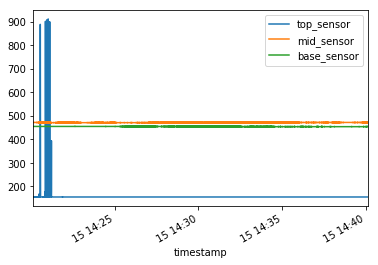

In [303]:
newDat['timestamp'] = pd.to_datetime(newDat['timestamp'])
newDat['delta'] = (newDat['timestamp']-newDat['timestamp'].shift()).fillna(pd.Timedelta(seconds=0))

newDat.plot(y=['top_sensor', 'mid_sensor', 'base_sensor'], x = "timestamp", style='-')

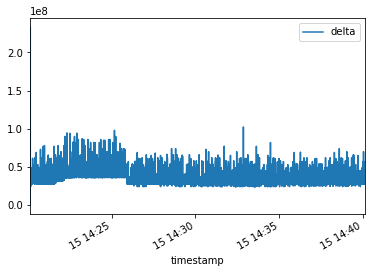

In [304]:
newDat.plot(y=['delta'], x = "timestamp", style='-')

In [305]:
newDat.head()

,base_sensor,mid_sensor,top_sensor,limit_1,limit_2,timestamp,delta
0,455,472,155,0,0,2019-02-15 14:20:07.921347,00:00:00
1,455,472,155,0,0,2019-02-15 14:20:07.957325,00:00:00.035978
2,455,472,155,0,0,2019-02-15 14:20:07.998302,00:00:00.040977
3,455,472,155,0,0,2019-02-15 14:20:08.231781,00:00:00.233479
4,455,472,155,0,0,2019-02-15 14:20:08.260782,00:00:00.029001


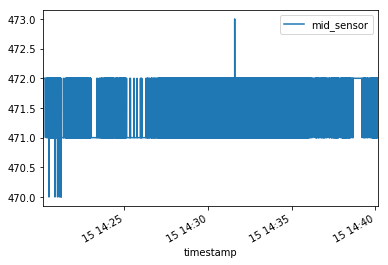

In [307]:
newDat.plot(y=['mid_sensor'], x = "timestamp", style='-')


# for com7
df1[["base_sensor", "mid_sensor", 
     "top_sensor", "limit_1", "limit_2"]] = \
    df1[["base_sensor", "mid_sensor", 
        "top_sensor", "limit_1", "limit_2"]].astype(int)

df1.head()

In [183]:
# for com8, switch base and mid refref, double check
tt = readData(ser1, readlen=10, wait_time=0.0, save=True, returnVals = True)
df1 = pd.DataFrame(tt, columns=["base_sensor", "mid_sensor", "top_sensor", "limit_1", "limit_2", "timestamp"])

df1[["mid_sensor", "base_sensor",
     "top_sensor", "limit_1", "limit_2"]] = \
    df1[["base_sensor", "mid_sensor", 
        "top_sensor", "limit_1", "limit_2"]].astype(int)

print(df1.shape)
df1.head()

2019_02_15__11_41_03_310824.csv
(10, 6)


,base_sensor,mid_sensor,top_sensor,limit_1,limit_2,timestamp
0,456,465,161,0,0,2019-02-15 11:41:03.310824
1,456,465,161,0,0,2019-02-15 11:41:03.331811
2,456,465,161,0,0,2019-02-15 11:41:03.352782
3,456,465,161,0,0,2019-02-15 11:41:03.372788
4,456,465,161,0,0,2019-02-15 11:41:03.392777


In [184]:
df1.tail()

,base_sensor,mid_sensor,top_sensor,limit_1,limit_2,timestamp
5,456,465,160,0,0,2019-02-15 11:41:03.412077
6,456,465,161,0,0,2019-02-15 11:41:03.425797
7,456,465,161,0,0,2019-02-15 11:41:03.455042
8,456,465,160,0,0,2019-02-15 11:41:03.467232
9,456,465,160,0,0,2019-02-15 11:41:03.490360


In [185]:
#np.array(df1.iloc[:,0].astype(int))

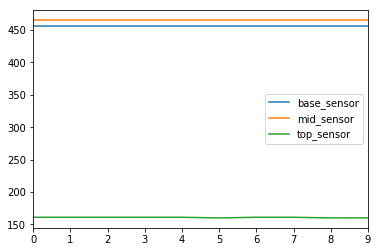

In [186]:
ax1 = df1.iloc[:, 0:3].plot()
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')  

In [ ]:
plt.plot(df1[["base_sensor", "mid_sensor", 
     "top_sensor"]])
plt.show()

In [ ]:
plt.plot(np.array(df1.iloc[:,1].astype(int)))

In [ ]:
plt.plot(np.array(df1.iloc[:,2].astype(int)))

In [ ]:
(tt[0, 5])

In [ ]:
# for com7
# top sensor
tt[:, 2]

# mid sensor
tt[:, 1]

# base sensor
tt[:, 0]

In [ ]:
plt.plot(tt[:,2])

In [ ]:
plt.plot(tt)

In [ ]:
#ser1.close()

In [ ]:
def moveToTop(serial_con, cutoff = 650):
    # refref: may want to go 1 or two more moves forward after cutoff is passed --- 
    ## the cutoff is the meniscus
    [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:, [1,3,4]]
    print(topVal)
    while (topVal > cutoff) and not topLim:
        #move forward
        ser1.write("f".encode("utf-8"))
        
        # read data again
        [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:,[1,3,4]]
        # rror if limit switch is hit
        if topLim:
            raise RuntimeError('Hit upper limit switch')
        
        
        
        

In [ ]:
# refref: problem -- liquid stays stuck on the sides -- may need to move back slower

def moveBack(serial_con, cutoff = 650):
    
    [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:, [1,3,4]]
    
    
    while (topVal < cutoff) and not bottomLim:
        #move backward
        for jj in range(7):
            ser1.write("b".encode("utf-8"))
            time.sleep(0.3)
        
        # read data again
        [[topVal, bottomLim, topLim]] = readData(serial_con, 1, 0)[:, [1,3,4]]
        # rror if limit switch is hit
        if bottomLim:
            raise RuntimeError('Hit lower limit switch')

In [ ]:
readData(ser1, 1, 0)

In [ ]:
moveToTop(ser1)
readData(ser1, 1, 0)

In [ ]:
moveBack(ser1)
readData(ser1, 1, 0)

In [ ]:
ser1.write("f".encode("utf-8"))

In [ ]:
[[vals, bottomLim, topLim]] = readData(ser1, 1, 0)[:, 2:]

In [ ]:
readData(ser1, 1, 0)[:, 2:]

In [ ]:
toplim = 1

In [ ]:
not toplim

for ii in range(20): 
    written = ser1.write("f".encode("utf-8"))


ser1.write("f".encode("utf-8"))

for ii in range(100): 
    written = ser1.write("b".encode("utf-8"))

"c".encode("utf-8")
int.from_bytes(b'c', byteorder='big') # this is what the arduino will see

int.from_bytes(b'c', byteorder='big')

ser1.write("c".encode("utf-8"))